### Imports


In [21]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json
from contextlib import contextmanager

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization

import pandas as pd
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow


import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocesamiento

In [ ]:
# copiamos la data desde nuestro drive hacia nuestra carpeta en colab
!cp "/content/drive/MyDrive/data_science/notebooks nuevas/AgeFace/data.rar" "/content/"
!unzip "/content/data.rar"
!mv "/content/content/AgePrediction" "/content/"
!rm -r "/content/content"

#### Funciones auxiliares

Funciones auxiliares encargadas de procesar los datos y crear los dataframes

In [12]:
# funcion encargada de leer las imagenes crudas
def load_data(path_directory):
    images = []
    ages = []
    genders = []
    dates = []
    races = []

    for filename in os.listdir(path_directory):
        if filename.endswith(".jpg"):
            split = filename.split('_')
            try:
                age = int(split[0])
                gender = int(split[1])
                race = int(split[2])
                date = str(split[3]).split('.')[0]

                images.append(filename)
                ages.append(age)
                genders.append(gender)
                races.append(race)
                dates.append(np.datetime64(date))

            except ValueError:
                print(f"Imagen: {filename} no cargada puesto que tiene el nombre fuera de formato")

    return images, ages, genders, races, dates


# funcion encargada de crear el dataframe de imagenes, edades, generos, razas y fecha cdo se tomo la foto
def create_dataframes(images, ages, genders, races, dates):

    images = pd.Series(list(images), name = 'Images')
    ages = pd.Series(list(ages), name = 'Ages')
    genders = pd.Series(list(genders), name = 'gender')
    races = pd.Series(list(races), name = 'Race')
    dates = pd.Series(list(dates), name = 'Date')

    result_df = pd.concat([images, ages, genders, races, dates], axis=1)
    result_df['Images'] = result_df['Images'].astype(str)
    return result_df

In [ ]:
def procesar_imagen(row, data_directory_data_raw, data_directory_data_prepro, face_cascade, pbar):
    try:

        img_path_from = os.path.join(data_directory_data_raw, row["Images"])
        img_path_to = os.path.join(data_directory_data_prepro, row["Images"])

        img = cv.imread(img_path_from)
        if img is not None:
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)
            if len(faces) > 0:
                for (x, y, w, h) in faces:
                    face = img[y:y+h, x:x+w]
                    cv.imwrite(img_path_to, face)
                pbar.update(1)  # Actualizar la barra de progreso
                return 0  # Cara detectada
            else:
                pbar.update(1)  # Actualizar la barra de progreso
                return 1  # No se detectó cara
        else:
            pbar.update(1)  # Actualizar la barra de progreso
            return 1  # No se pudo leer la imagen
    except:
        pbar.update(1)  # Actualizar la barra de progreso en caso de excepción
        return 1  # Excepción durante el procesamiento

def resize_imgs(df, data_directory_path):

    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

    data_directory_data_raw = os.path.join(data_directory_path, "data_raw")
    data_directory_data_prepro = os.path.join(data_directory_path, "prepro")

    # Crear un tqdm para el bucle
    with tqdm(total=len(df), desc="Redimensionando imágenes") as pbar:
        # Aplicar la función a cada fila del DataFrame
        not_face_count = df.apply(procesar_imagen, axis=1,
                                  args=(data_directory_data_raw, data_directory_data_prepro, face_cascade, pbar))\
                                  .sum()

def eliminar_imagenes_pequenas(directorio, ancho_minimo, alto_minimo):
    count_deleted_files = 0

    for filename in os.listdir(directorio):
        if filename.endswith(".jpg") or filename.endswith(".png"): # Ajusta los formatos según sea necesario
            ruta = os.path.join(directorio, filename)
            img = cv.imread(ruta)
            alto, ancho = img.shape[:2]
            if (ancho < ancho_minimo )| (alto < alto_minimo):
                os.remove(ruta)
                count_deleted_files += 1
    print(f"Se eliminaron un total de {count_deleted_files} fotos")

def eliminar_no_faces(directorio, face_cascade):
    count_deleted_files = 0

    for filename in os.listdir(directorio):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            ruta = os.path.join(directorio, filename)
            img = cv.imread(ruta)

            if img is not None:
                gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, 1.1, 4)

                if len(faces) == 0:
                    os.remove(ruta)
                    count_deleted_files += 1

    print(f"Se eliminaron un total de {count_deleted_files} fotos")

#### Prerpo

En el preprocesamiento haremos lo siguiente:

* Recortaremos la imagen quedandonos solo con el rostro que aparece en al foto.
* Construiremos un ImageDataGenerator para realizar data augmentation.
* **NO** vamos a predecir un valor continuo, vamos a transformar nuestro problema de resgresion en un problema de clasificacion, i.e nuestras edades las trataremos como valores discretos.

In [ ]:
# cargamos la data raw y la preprocesamos
images, ages, genres, races, dates = load_data("/content/AgePrediction/data/data_raw")
df = create_dataframes(images, ages, genres, races, dates)
df.head()

In [ ]:
!mkdir data/prepro

In [ ]:
resize_imgs(df, "/content/AgePrediction/data/")

Redimensionando imágenes: 100%|██████████| 24102/24102 [34:16<00:00, 11.72it/s]


In [ ]:
# checkeamos
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
eliminar_no_faces("/content/AgePrediction/data/prepro",face_cascade)


Se eliminaron un total de 5128 fotos


#### Load data prepro

In [13]:
try:
  os.chdir('/content/AgePrediction')
  cwd = os.getcwd()

  print("Current working directory is:", cwd)
except:

  cwd = os.getcwd()
  print("2Current working directory is:", cwd)

Current working directory is: /content/AgePrediction


In [14]:
# cargamos las imagenes preprocesadas
images, ages, genres, races, dates = load_data("/content/AgePrediction/data/prepro")

# creamos el dataframe
df_prepro = create_dataframes(images, ages, genres, races, dates)
df_prepro.head()

Imagen: 24_0_1_20170116220224657 .jpg no cargada puesto que tiene el nombre fuera de formato


,Images,Ages,gender,Race,Date
0,54_1_0_20170110122945745.jpg,54,1,0,20170110122945745
1,24_0_2_20170104020029454.jpg,24,0,2,20170104020029454
2,30_0_0_20170117144027577.jpg,30,0,0,20170117144027577
3,28_1_2_20170116164612760.jpg,28,1,2,20170116164612760
4,31_0_0_20170104165835728.jpg,31,0,0,20170104165835728


### Modelado

* Construiremos una cnn cuya tarea sera la de un multiple-clasificador.
  * Construiremos una cnn baseline.
  * Construiremos una cnn mas compleja.
  * Haremos uso de transfer learning y adaptar este modelo(VGG16) a nuestro problema .

In [15]:
path = "/content/AgePrediction/data/prepro"
df_prepro["photo_dir"] = path + "/" + df_prepro["Images"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_prepro[["photo_dir", "Ages",]],
                                                    df_prepro[["Ages"]],
                                                    train_size=.8,
                                                    random_state=73)

In [17]:
X_train

,photo_dir,Ages
8324,/content/AgePrediction/data/prepro/24_1_3_2017...,24
4378,/content/AgePrediction/data/prepro/65_0_0_2017...,65
3804,/content/AgePrediction/data/prepro/4_1_0_20170...,4
10435,/content/AgePrediction/data/prepro/48_0_3_2017...,48
11371,/content/AgePrediction/data/prepro/15_1_4_2017...,15
...,...,...
8513,/content/AgePrediction/data/prepro/70_0_0_2017...,70
13704,/content/AgePrediction/data/prepro/56_1_0_2017...,56
16144,/content/AgePrediction/data/prepro/1_0_3_20161...,1
8586,/content/AgePrediction/data/prepro/54_0_3_2017...,54


In [ ]:
# ImageDataGenerator para el conjunto de entrenamiento con aumentos de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator para el conjunto de prueba sin aumentos de datos, solo normalización
test_datagen = ImageDataGenerator(
    rescale=1/255.0
)

# Generador para el conjunto de entrenamiento
train_data = train_datagen.flow_from_dataframe(
    dataframe=X_train,  # DataFrame de entrenamiento
    x_col='photo_dir',
    y_col='Ages',  # Nombre de la columna de destino
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    seed=42
)

# Generador para el conjunto de prueba
test_data = test_datagen.flow_from_dataframe(
    dataframe=X_test,  # DataFrame de prueba
    x_col='photo_dir',
    y_col='Ages',  # Nombre de la columna de destino
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='raw',
    shuffle=False  # no queremos mezclar el conjunto de prueba
)

Found 13364 validated image filenames.
Found 3342 validated image filenames.


In [18]:
!mkdir models

#### Funciones auxiliares

In [24]:
def cargar_foto(path_photo, model):
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    img = cv.imread(path_photo)

    if img is not None:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        if len(faces) > 0:
            for (x, y, w, h) in faces:
                face = img[y:y+h, x:x+w]

                cv2_imshow(face)
                face = cv.resize(face, (224, 224))
                face = face.astype('float32') / 255.0  # Normalizar la imagen

                # Preprocesar la imagen para el modelo
                face_array = np.expand_dims(face, axis=0)
                print(face_array.shape)  # Añadir una dimensión para el batch
                #face_array = preprocess_input(face_array)  # Preprocesamiento específico de VGG16

                return model.predict(face_array)

#### model_v3

In [ ]:
!mkdir AgePrediction/models/model_v3

In [ ]:
# Cargar la base del modelo VGG16 preentrenado
model_vgg16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224, 224, 3))

# Congelar los pesos de todas las capas excepto las últimas 4
for layer in model_vgg16.layers[:-2]:
    layer.trainable = False

x = Flatten()(model_vgg16.output)

# Primera capa densa
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Segunda capa densa
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Tercera capa densa
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Capa de salida para regresión
predictions = Dense(1)(x)

model_v3 = Model(inputs=model_vgg16.input, outputs=predictions)

# Añadir Callbacks
early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mejor_modelo.h5', monitor='val_mae', save_best_only=True)

# Compilar el modelo
model_v3.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error', metrics=['mae'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_v3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Entrenar el modelo
history_model_v3 = model_v3.fit(
    train_data,
    epochs=50,
    validation_data=test_data,
    callbacks=[early_stopping, model_checkpoint]
)

with open('/content/AgePrediction/models/model_v3/historia_entrenamiento.json', 'w') as f:
    json.dump(history_model_v3.history, f)

# guardar el modelo en colab y copiarlo al drive
model_v3.save("/content/AgePrediction/models/model_v3/model_v3_final.keras")
!cp "/content/AgePrediction/models/model_v3/model_v3_final.keras" "/content/drive/MyDrive/data_science/notebooks nuevas/AgeFace/model_v3_final.keras"

# guardamos los pesos
model_v3.save_weights('/content/drive/MyDrive/data_science/notebooks nuevas/AgeFace/model_v3_final_weights.h5')


Epoch 1/50
418/418 [==============================] - ETA: 0s - loss: 722.1340 - mae: 22.1618

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


418/418 [==============================] - 183s 407ms/step - loss: 722.1340 - mae: 22.1618 - val_loss: 256.3453 - val_mae: 11.7464
Epoch 2/50
418/418 [==============================] - 162s 387ms/step - loss: 163.5344 - mae: 9.6327 - val_loss: 139.7191 - val_mae: 9.0115
Epoch 3/50
418/418 [==============================] - 161s 386ms/step - loss: 148.5163 - mae: 9.1770 - val_loss: 108.5323 - val_mae: 7.4339
Epoch 4/50
418/418 [==============================] - 160s 382ms/step - loss: 145.5427 - mae: 9.0250 - val_loss: 204.4143 - val_mae: 11.3005
Epoch 5/50
418/418 [==============================] - 161s 385ms/step - loss: 136.4472 - mae: 8.7871 - val_loss: 167.4160 - val_mae: 8.7968
Epoch 6/50
418/418 [==============================] - 160s 383ms/step - loss: 131.5156 - mae: 8.5757 - val_loss: 104.1255 - val_mae: 7.7052
Epoch 7/50
418/418 [==============================] - 163s 389ms/step - loss: 127.8709 - mae: 8.4716 - val_loss: 106.9661 - val_mae: 7.3904
Epoch 8/50
418/418 [========

In [29]:
model_v3 = load_model('/content/drive/MyDrive/data_science/notebooks nuevas/AgeFace/model_v3_final.keras')

In [34]:
from google.colab import files
uploaded = files.upload()

Saving vieja_error.png to vieja_error.png


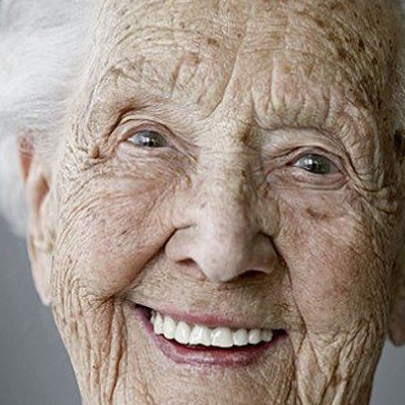

(1, 224, 224, 3)
1/1 [==============================] - 0s 149ms/step


array([[105.935646]], dtype=float32)

In [36]:
path_photo = "vieja_error.png"
cargar_foto(path_photo, model_v3)